# ***NoNino Project***

# Exploratory Data Analysis

Import Packages

In [67]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install scikit-learn pandas numpy tensorflow seaborn mplfinance


Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.6 MB/s eta 0:00:00


In [69]:
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns

import pandas as pd

import joblib

import mplfinance as mpf

import xgboost as xgb

import numpy as np

import tensorflow as tf
import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, BatchNormalization

import torch.nn as nn
import torch.optim as optim
import torch

import matplotlib.pyplot as plt

In [33]:
data = pd.read_csv("/content/elnino.csv")

In [34]:
data = data.drop(columns=['Observation', ' Date', ' Year', ' Humidity'])

In [35]:
print(data.columns)
print(f"Max and Min of Meridional Wins Respectively: Max:{max(data[' Meridional Winds'])} and Min:{min(data[' Meridional Winds'])}")

Index([' Month', ' Day', ' Latitude', ' Longitude', ' Zonal Winds',
       ' Meridional Winds', ' Air Temp', ' Sea Surface Temp'],
      dtype='object')
Max and Min of Meridional Wins Respectively: Max:9.9 and Min:-0.1


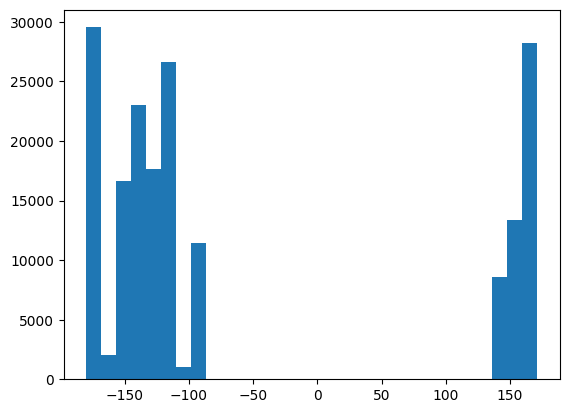

In [36]:
plt.hist(x=data[' Longitude'], bins=30)
plt.show()

In [37]:
def season(x):
  if x >=1 and x <= 2:
    return "Winter"
  elif x >= 3 and x <= 5:
    return "Spring"
  elif x >= 6 and x <= 8:
    return "Summer"
  elif x >= 9 and x <= 11:
    return "Autumn"
  else:
    return "Winter"

data['Season'] = data[' Month'].apply(season)

# Create a mapping for seasons to integers
season_map = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4}

# Map the season names to integers
data['Season'] = data['Season'].map(season_map)
print(data.dtypes)
data.iloc[0]

 Month                 int64
 Day                   int64
 Latitude            float64
 Longitude           float64
 Zonal Winds          object
 Meridional Winds     object
 Air Temp             object
 Sea Surface Temp     object
Season               float64
dtype: object


,0
Month,3
Day,7
Latitude,-0.02
Longitude,-109.46
Zonal Winds,-6.8
Meridional Winds,0.7
Air Temp,26.14
Sea Surface Temp,26.24
Season,2.0


In [38]:
scaler = StandardScaler()
data[[' LatitudeScaled', ' LongitudeScaled']] = scaler.fit_transform(data[[' Latitude', ' Longitude']])

In [39]:
num_clusters = 12
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# Fit the model to your data (using only the x and y columns)
data['cluster'] = kmeans.fit_predict(data[[' LatitudeScaled', ' LongitudeScaled']])

In [64]:
joblib.dump(kmeans, 'kmeans_model.pkl')

['kmeans_model.pkl']

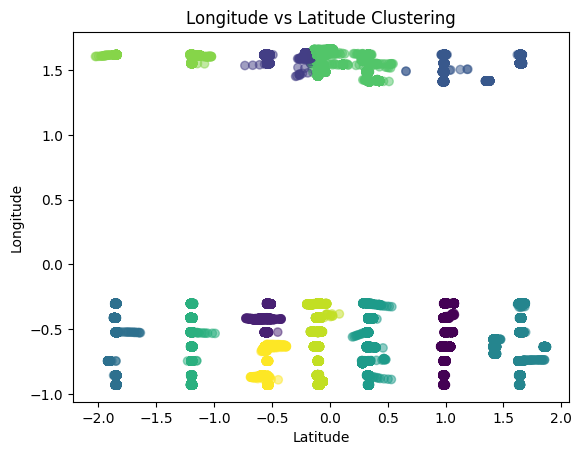

In [65]:
#plt.scatter(x=data[' Latitude'], y=data[' Longitude'], alpha=0.1)
plt.scatter(data[' LatitudeScaled'], data[' LongitudeScaled'], c=data['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Longitude vs Latitude Clustering")
plt.show()

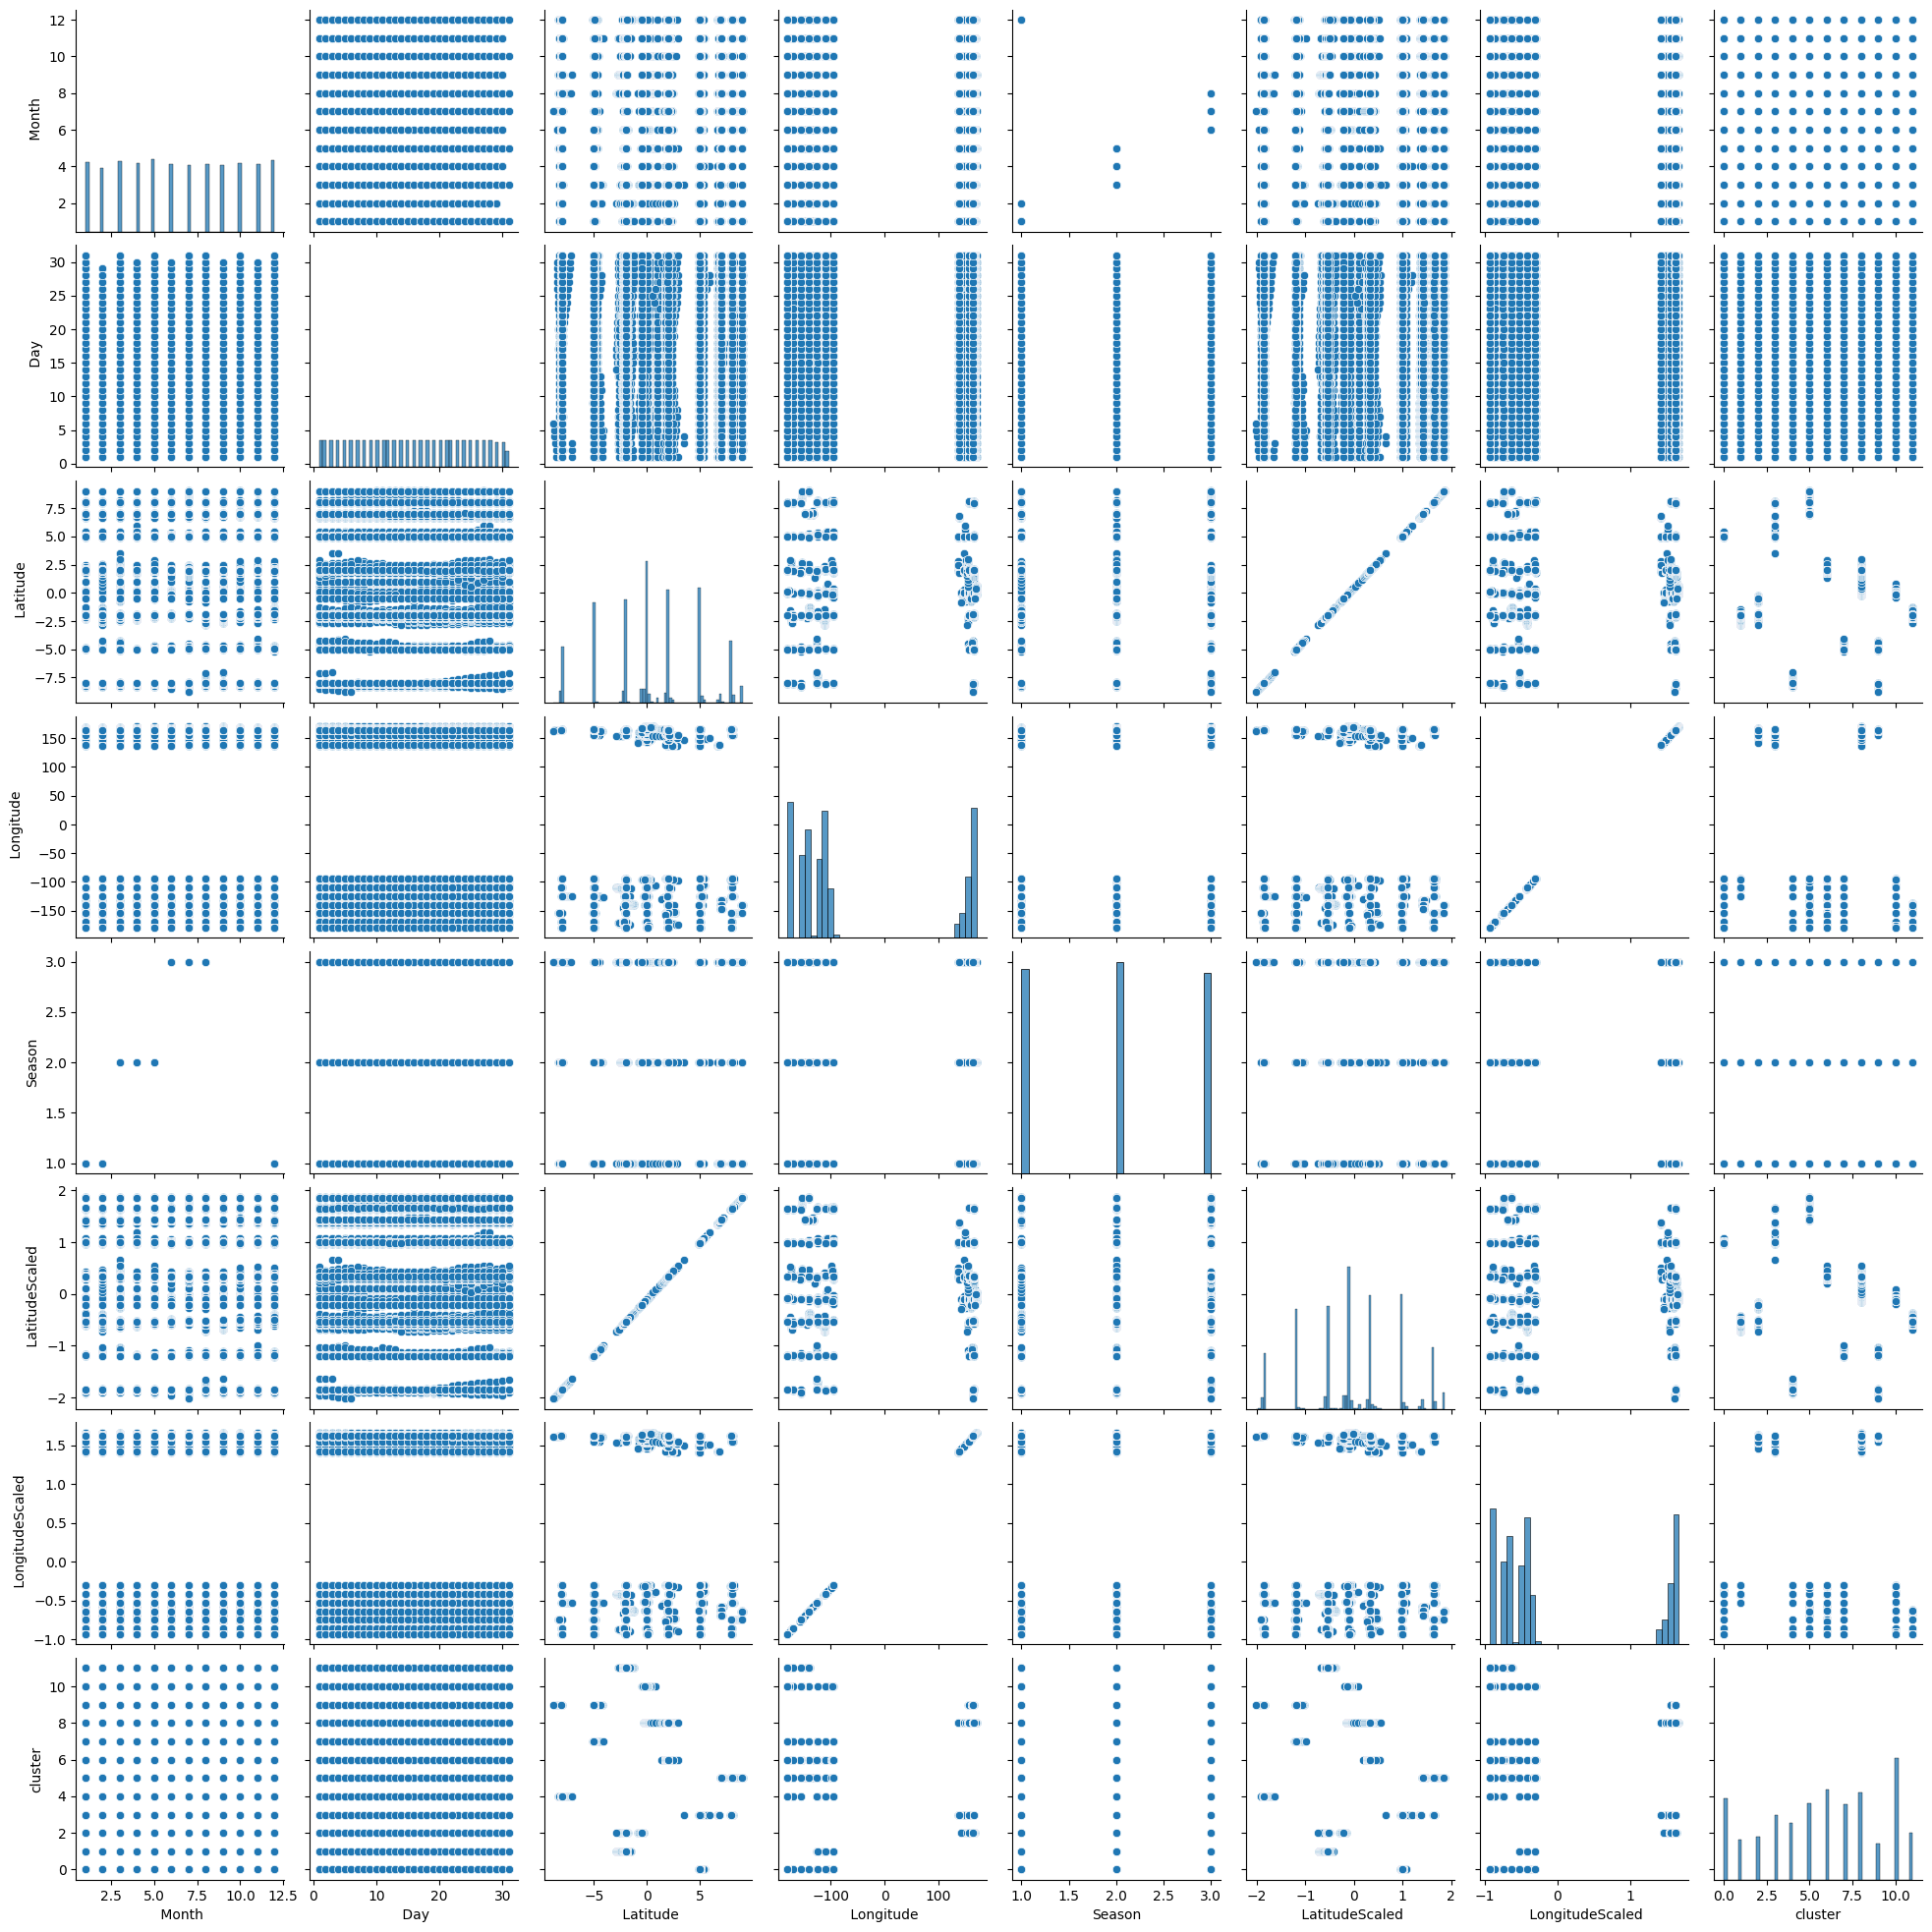

In [41]:
sns.pairplot(data)

Maybe clustering them would be a smart idea

# Machine Learning

In [42]:
ttData = data[[' Zonal Winds',
       ' Meridional Winds', ' Air Temp', ' Sea Surface Temp', ' Month', ' Day', ' Latitude', ' Longitude', 'cluster', 'Season']].dropna()

# Convert object columns to float, coercing errors
for column in ttData.select_dtypes(include=['object']).columns:
    ttData[column] = pd.to_numeric(data[column], errors='coerce')

ttData = ttData.dropna()
print(f"Samples: {len(ttData)}")

Samples: 97863


In [43]:
y = ttData[[' Meridional Winds', ' Air Temp', ' Sea Surface Temp']]  # Features as NumPy array
X = ttData[[' Month', ' Day', ' Latitude', ' Longitude', 'cluster', 'Season']]    # Target as NumPy array

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
y.iloc[0]

,0
Meridional Winds,0.70
Air Temp,26.14
Sea Surface Temp,26.24


In [46]:
# Create the XGBoost regressor
xgb_model = xgb.XGBRegressor()

# Wrap it with MultiOutputRegressor
xgboost = MultiOutputRegressor(xgb_model)

# Fit the model
xgboost.fit(X_train, y_train)

# Make predictions
predictions = xgboost.predict(X_test)

In [47]:
# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Squared Error: {mae}')

print(f"Predictions: {predictions.flatten()[0:6]}")
flattened_list = [item for sublist in y_test.values.tolist() for item in sublist]
print(f"Actuals: {flattened_list[0:6]}")

Mean Squared Error: 0.8301802543519344
Predictions: [ 1.6235083 26.677326  27.566793   2.4542782 26.604414  28.339947 ]
Actuals: [1.5, 27.22, 27.98, -1.3, 28.08, 29.05]


That represents total error

In [48]:
# Calculate MSE and NMSE for each output
nmse_values = {}
for i, col in enumerate(y_test.columns):
    mse = np.mean((y_test[col].values - predictions[:, i]) ** 2)
    variance = np.var(y_test[col].values)
    nmse = mse / variance if variance != 0 else float('inf')  # Avoid division by zero
    nmse_values[col] = nmse
print(nmse_values)

{' Meridional Winds': 0.4134443133389398, ' Air Temp': 0.1690490388283957, ' Sea Surface Temp': 0.1168703977631379}


In [49]:
# Save each model in the MultiOutputRegressor
for i, xgboost in enumerate(xgboost.estimators_):
    xgboost.save_model(f'xgboost_model_{i}.json')

# Deep Learning

In [50]:
def create_model(input_shape):
    model = keras.Sequential([
        Input(shape=input_shape),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(3)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create and train the model
model = create_model(X_train.shape[1:])

In [51]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/20
1958/1958 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 62.3747 - val_loss: 3.4331
Epoch 2/20
1958/1958 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3.4185 - val_loss: 2.7948
Epoch 3/20
1958/1958 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3.0803 - val_loss: 2.6713
Epoch 4/20
1958/1958 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.0366 - val_loss: 2.6797
Epoch 5/20
1958/1958 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 3.0057 - val_loss: 2.6896
Epoch 6/20
1958/1958 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3.0219 - val_loss: 2.4716
Epoch 7/20
1958/1958 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 2.9675 - val_loss: 2.6635
Epoch 8/20
1958/1958 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2.9602 - val_loss: 2.4990
Epoch 9/20
1958/1958 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 2.9418 - val_loss: 2.4678
Epoch 10/20
1958/1958 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.8976 - val_loss: 2.5104
Epoch 11/20
1958/1958 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.9209 - val_loss: 2.4917
Epoch 12/20
1958/1958 ━━━━━━

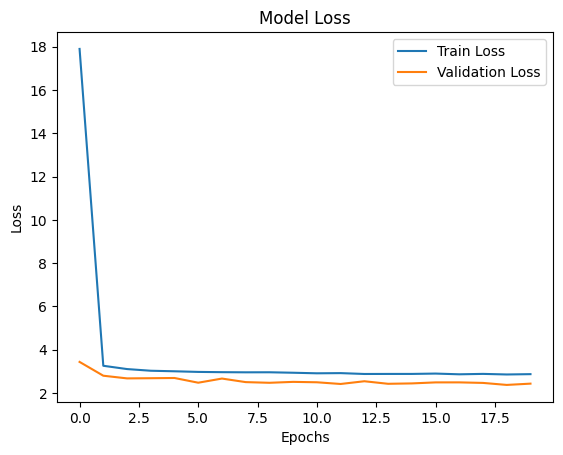

In [52]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
print(f"Predictions: {predictions.flatten()[0:6]}")
flattened_list = [item for sublist in y_test.values.tolist() for item in sublist]

print(f"Actuals: {flattened_list[0:6]}")

Predictions: [ 1.4892988 26.924372  27.979855   1.3317041 24.777145  25.168201 ]
Actuals: [1.5, 27.22, 27.98, -1.3, 28.08, 29.05]


# Graphs

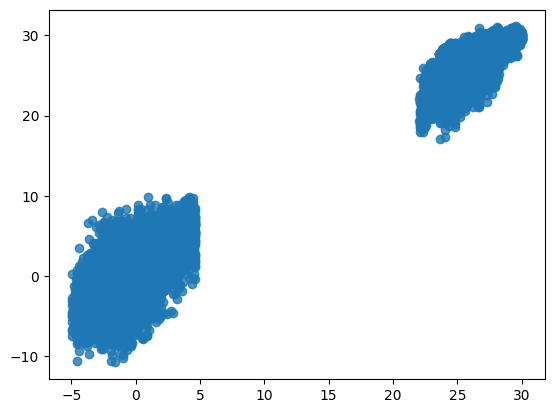

In [54]:
plt.scatter(x=predictions.flatten(), y=flattened_list, alpha=0.8)
plt.show()

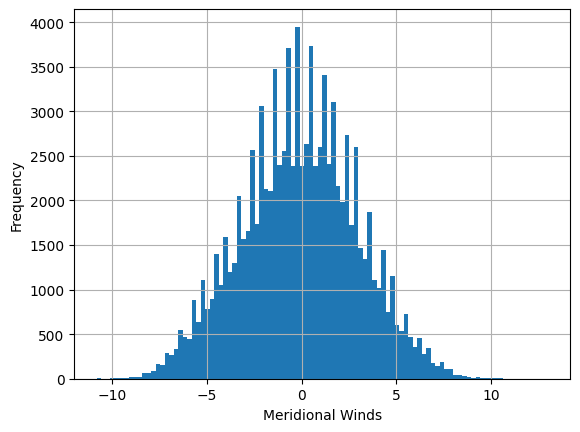

In [60]:
plt.hist(x=ttData[' Meridional Winds'], bins=100)
plt.xlabel("Meridional Winds")
plt.ylabel("Frequency")
plt.grid()
plt.show()

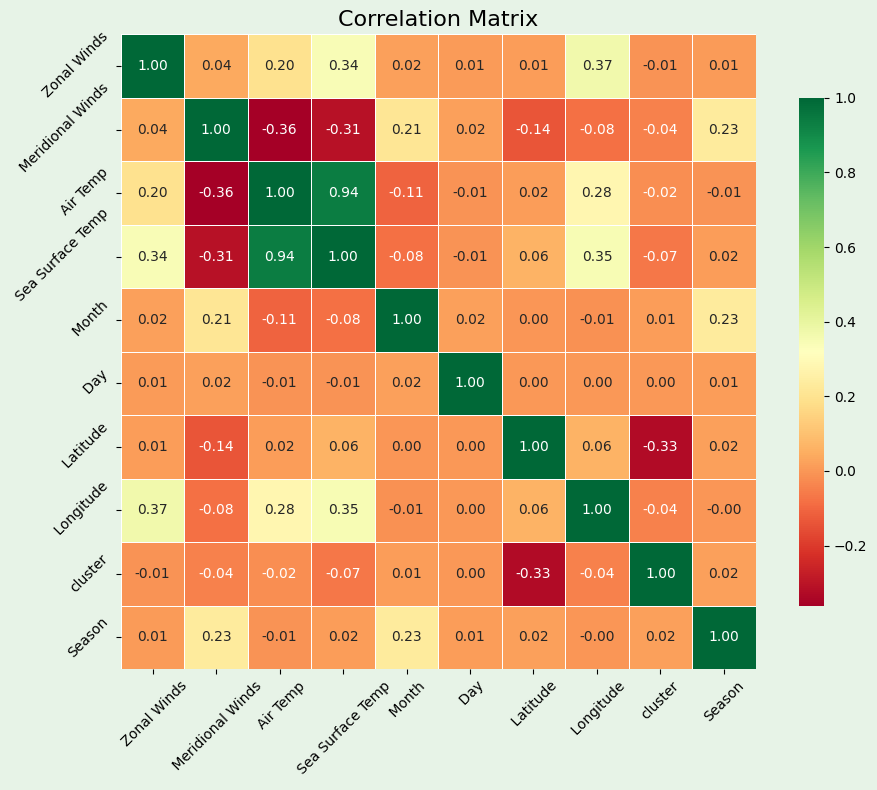

In [66]:
# Step 1: Calculate the correlation matrix
correlation_matrix = ttData.corr()

# Step 2: Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8), facecolor="#e7f3e7")  # Adjust the size as needed

farm_colors = sns.color_palette("RdYlGn", as_cmap=True)  # Red to Yellow to Green

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap=farm_colors,
            square=True, cbar_kws={"shrink": .8}, linewidths=0.5)

# Set titles and labels
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

In [ ]:
# Create a candlestick chart
mpf.plot(ttData[' Month'], type='candle', style='charles', title='Candlestick Chart Example',
         ylabel='Price', volume=False)

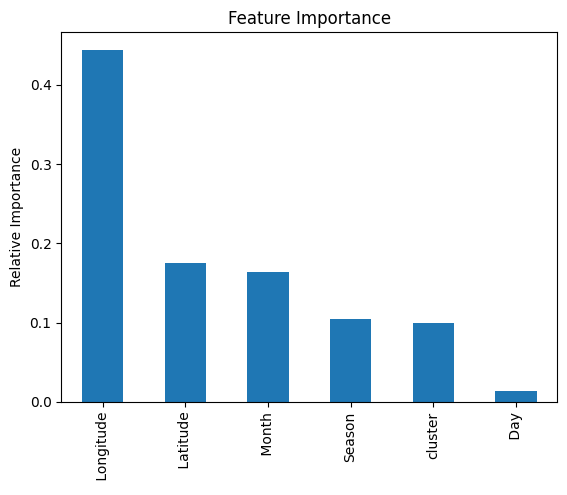

In [71]:
feature_imp = pd.Series(xgboost.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot feature importances
ax = feature_imp.plot(kind='bar', )
ax.set(ylabel='Relative Importance')
plt.title('Feature Importance')
plt.show()